# Align spike sequences in GISAID and count RBD mutations
This Python Jupyter notebook reads in a file of all spike sequences from GISAID, parses for "high-quality" sequences, builds a RBD alignment, and then makes a file that gives the counts of each mutation at each site.

## Set up analysis
Import Python modules:

In [1]:
import io
import lzma
import os
import re
import subprocess

from Bio.Data.IUPACData import protein_letters
import Bio.SeqIO
from Bio.Seq import Seq

from IPython.display import display, HTML

import matplotlib.pyplot as plt

import pandas as pd

from plotnine import *

import yaml

%matplotlib inline

Read the configuration file:

In [2]:
with open('config.yaml') as f:
    config = yaml.safe_load(f)

Create output directory:

In [3]:
os.makedirs(config['gisaid_mutations_dir'], exist_ok=True)

## Parse full-length human human spike sequences

Read the spikes from the file downloaded from GISAID:

In [4]:
print(f"Reading GISAID sequences (whole genome) in {config['spike_sequences']}")
spikes = list(Bio.SeqIO.parse(config['spike_sequences'], 'fasta'))   
print(f"Read {len(spikes)} sequences.")

Reading GISAID sequences (whole genome) in results/GISAID_mutations/spike_sequences.fasta
Read 236114 sequences.


Make a data frame that has the BioPython SeqRecord, length, host, and geographic location (country) for each spike.
Also determine whether sequences have ambiguous amino acids or are all valid amino acids:

In [5]:
spikes_df = (
    pd.DataFrame({'seqrecord': spikes})
    .assign(description=lambda x: x['seqrecord'].map(lambda rec: rec.description),
            country=lambda x: x['description'].str.split('@').str[0],
            length=lambda x: x['seqrecord'].map(len),
            n_ambiguous=lambda x: x['seqrecord'].map(lambda rec: rec.seq.count('N') + rec.seq.count('n')),
            )
    )

Finally, we get rid of spikes with **lots** of ambiguous residues as they may hinder the alignment below.
We will then do more detailed filtering for ambiguous residues just in the RBD region after alignment:

In [6]:
max_ambiguous = 500
print(f"Filtering sequences with > {max_ambiguous} ambiguous residues")
spikes_df = (
    spikes_df
    .assign(excess_ambiguous=lambda x: x['n_ambiguous'] > max_ambiguous)
    )
display(HTML(
    spikes_df
    .groupby('excess_ambiguous')
    .aggregate(n_sequences=pd.NamedAgg('seqrecord', 'count'))
    .to_html()
    ))

Filtering sequences with > 500 ambiguous residues


,n_sequences
excess_ambiguous,
False,236015
True,99


## Align the RBD region of the spikes
We now align the RBD regions of the spikes.
We do this **before** we filter sequences with too many ambiguous residues so that we can do that filtering just on the RBD region.

We align with `mafft` using the `--addfragments` and `--keeplength` options (see [here](https://mafft.cbrc.jp/alignment/software/closelyrelatedviralgenomes.html) and [here](https://mafft.cbrc.jp/alignment/software/addsequences.html)) to align relative to a reference that is just the RBD; these options also clip the sequences relative to the reference.
Note that these options make sense if the following conditions are met:
  1. Sequences are all very similar.
  2. We are not worried about insertions.
For now, both of these appear to be true, but this choice should be kept in mind if there is a lot more divergence or insertions.

We align relative to the reference that is the wildtype sequence used for the experiments:

In [7]:
print(f"Reading reference nucleotide sequence in {config['RBD_sequence_Omicron_BA2']}")
refseq = Bio.SeqIO.read(config['RBD_sequence_Omicron_BA2'], 'fasta')

refntfile = os.path.join(config['gisaid_mutations_dir'], 'reference_RBD.fasta')
print(f"Writing nt seq of reference sequence to {refntfile}")
refseq.seq = refseq.seq
_ = Bio.SeqIO.write(refseq, refntfile, 'fasta')

Reading reference nucleotide sequence in data/RBD_BA2_seq.fasta
Writing nt seq of reference sequence to results/GISAID_mutations/reference_RBD.fasta


Now make the alignment.
Note that we use multiple threads to speed things up, and also align the spikes in chunks.
The reason that we have to the chunkwise alignment is that some unclear `mafft` error was arising if we tried to align them all at once:

In [8]:
chunksize = 50000

aligned_rbds = []

for i in range(0, len(spikes_df), chunksize):
    spikes_file = os.path.join(config['gisaid_mutations_dir'],
                               f"human_full-length_spikes_{i + 1}-to-{i + chunksize}.fasta")
    print(f"Writing spikes {i + 1} to {i + chunksize} to {spikes_file}")
    _ = Bio.SeqIO.write(spikes_df['seqrecord'].tolist()[i: i + chunksize], spikes_file, 'fasta')
    print('Now aligning these sequences...')
    cmds = ['mafft', '--auto', '--thread', str(config['max_cpus']),
            '--keeplength', '--addfragments', spikes_file, refntfile]
    res = subprocess.run(cmds, capture_output=True)
    if res.returncode:
        raise RuntimeError(f"Error in alignment:\n{res.stderr}")
    else:
        print('Alignment complete.\n')
        with io.StringIO(res.stdout.decode('utf-8')) as f:
            iseqs = list(Bio.SeqIO.parse(f, 'fasta'))
            # remove reference sequence, which should be first in file
            assert iseqs[0].description == refseq.description
            iseqs = iseqs[1:]
            assert len(iseqs) == min(chunksize, len(spikes_df) - i)
            aligned_rbds += iseqs
            
assert len(aligned_rbds) == len(spikes_df)

Writing spikes 1 to 50000 to results/GISAID_mutations/human_full-length_spikes_1-to-50000.fasta
Now aligning these sequences...
Alignment complete.

Writing spikes 50001 to 100000 to results/GISAID_mutations/human_full-length_spikes_50001-to-100000.fasta
Now aligning these sequences...
Alignment complete.

Writing spikes 100001 to 150000 to results/GISAID_mutations/human_full-length_spikes_100001-to-150000.fasta
Now aligning these sequences...
Alignment complete.

Writing spikes 150001 to 200000 to results/GISAID_mutations/human_full-length_spikes_150001-to-200000.fasta
Now aligning these sequences...
Alignment complete.

Writing spikes 200001 to 250000 to results/GISAID_mutations/human_full-length_spikes_200001-to-250000.fasta
Now aligning these sequences...
Alignment complete.



## Parse / filter aligned RBDs

Now put all of the aligned RBDs into a data frame to filter and parse, while translating the aligned sequences to amino acid sequences:

In [9]:
rbd_df = (
    pd.DataFrame({'seqrecord': aligned_rbds})
    .assign(description=lambda x: x['seqrecord'].map(lambda rec: rec.description),
            country=lambda x: x['description'].str.split('@').str[0],
            length=lambda x: x['seqrecord'].map(len),
            n_ambiguous=lambda x: x['seqrecord'].map(lambda rec: rec.seq.count('N') + rec.seq.count('n')),
            n_gaps=lambda x: x['seqrecord'].map(lambda rec: rec.seq.count('-')),
            )
    )

assert all(rbd_df['length'] == len(refseq))

Plot number of gaps and ambiguous nucleotides among sequences:

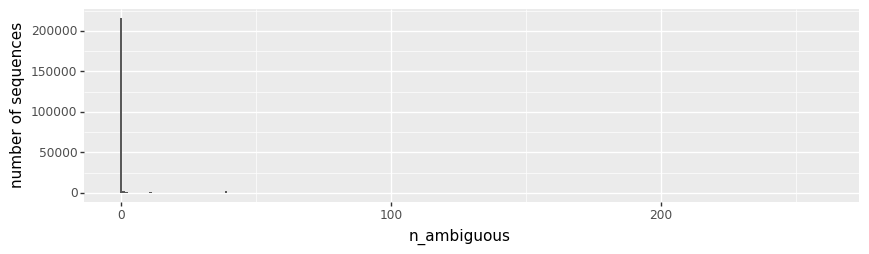

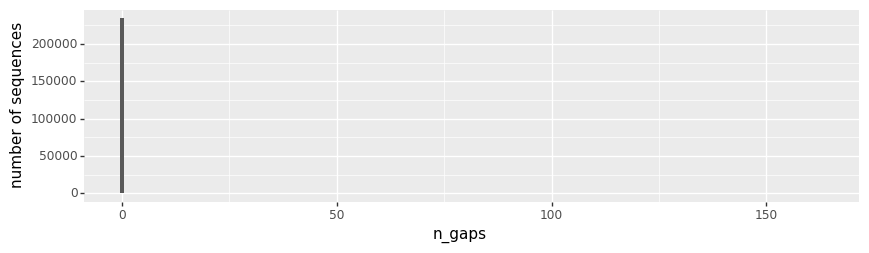

In [10]:
for prop in ['n_ambiguous', 'n_gaps']:
    p = (ggplot(rbd_df) +
         aes(prop) +
         ylab('number of sequences') +
         theme(figure_size=(10, 2.5)) +
         geom_bar()
         )
    _ = p.draw()

Based on above plots, we will retain just RBDs with no ambiguous amino acids and no gaps:

In [11]:
rbd_df = rbd_df.query('n_ambiguous == 0').query('n_gaps == 0')
print(f"Retained {len(rbd_df)} RBDs.")

Retained 214472 RBDs.


Now get and plot the number of nt mutations per RBD relative to the reference sequence, plotting on both a linear and log scale.
We then filter all RBDs that have more than some maximum number of mutations, based on the idea that ones that are extremely highly mutated probably are erroneous.
**Note that this maximum number of mutations will change over time, so should be re-assessed periodically by looking at below plots.**

In [12]:
max_muts = 15

refseq_str = str(refseq.seq.translate())
rbd_df = (
    rbd_df
    .assign(seq=lambda x: x['seqrecord'].map(lambda rec: str(rec.seq.translate())),
            n_mutations=lambda x: x['seq'].map(lambda s: sum(x != y for x, y in zip(s, refseq_str))))
    )

p = (ggplot(rbd_df) +
     aes('n_mutations') +
     geom_bar() +
     theme(figure_size=(10, 2.5)) +
     geom_vline(xintercept=max_muts + 0.5, color='red', linetype='dotted')
     )
_ = p.draw()
_ = (p + scale_y_log10()).draw()

rbd_df = rbd_df.query('n_mutations <= @max_muts')

Write RBD sequences that pass filtering to a file:

In [13]:
print(f"Overall, there are {len(rbd_df)} aligned RBDs that passed filters.")

rbd_alignment_file = os.path.join(config['gisaid_mutations_dir'], 'RBD_alignment.fasta')
print(f"Writing alignment to {rbd_alignment_file}")
_ = Bio.SeqIO.write(rbd_df['seqrecord'].tolist(), rbd_alignment_file, 'fasta')

Overall, there are 214299 aligned RBDs that passed filters.
Writing alignment to results/GISAID_mutations/RBD_alignment.fasta


## Get counts of each mutation
Now we get a data frame that gives the count of each amino acid mutation at each site:

In [14]:
records = []
for tup in rbd_df[['seq', 'country']].itertuples():
    for isite, (mut, wt) in enumerate(zip(tup.seq, refseq_str), start=1):
        if mut != wt:
            records.append((isite, isite + config['site_number_offset'], wt, mut, tup.country))
            
muts_df = (pd.DataFrame.from_records(records,
                                     columns=['isite', 'site', 'wildtype', 'mutant', 'country'])
           .groupby(['isite', 'site', 'wildtype', 'mutant'])
           .aggregate(count=pd.NamedAgg('country', 'count'),
                      n_countries=pd.NamedAgg('country', 'nunique'))
           .reset_index()
           .sort_values('count', ascending=False)
           .assign(frequency=lambda x: x['count'] / len(rbd_df))
           )

print('Here are first few lines of mutation counts data frame:')
display(HTML(muts_df.head(n=15).to_html(index=False)))

Here are first few lines of mutation counts data frame:


isite,site,wildtype,mutant,count,n_countries,frequency
110,440,K,X,9953,17,0.046444
110,440,K,N,3397,54,0.015852
78,408,S,X,2779,16,0.012968
41,371,F,X,2652,12,0.012375
78,408,S,R,1891,42,0.008824
46,376,A,T,1092,37,0.005096
147,477,N,S,772,17,0.003602
45,375,F,S,771,21,0.003598
168,498,R,Q,767,23,0.003579
9,339,D,G,743,16,0.003467


Plot how many mutations are observed how many times:

In [15]:
p = (ggplot(muts_df) +
     aes('count') +
     geom_histogram(bins=20) +
     scale_x_log10() +
     ylab('number of sequences') +
     xlab('times mutation observed')
     )

_ = p.draw()

Write the mutation counts to a file:

In [16]:
print(f"Writing mutation counts to {config['gisaid_mutations_dir']}")
muts_df.to_csv(config['gisaid_mutation_counts'], index=False)

Writing mutation counts to results/GISAID_mutations
